⚠️ If you are mounting your google drive in Colab, run the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy

In [ ]:
import os
from collections import Counter
from  tqdm import tqdm
import numpy as np
import pandas as pd

Using SciPy No module named 'cuml'


In [ ]:
%%writefile install.sh
current=$(pwd)

# download boost
wget https://boostorg.jfrog.io/artifactory/main/release/1.77.0/source/boost_1_77_0.tar.gz
tar -xf boost_1_77_0.tar.gz

# install boost
cd boost_1_77_0

./bootstrap.sh --with-libraries=program_options,iostreams
./b2 install

cd $current

Writing install.sh


In [ ]:
!sh install.sh &> /dev/null

In [ ]:
%%writefile install-prereq.sh

# install seqtk
current=$(pwd)
git clone https://github.com/lh3/seqtk.git;
cd seqtk; make

# install wtdbg2
cd $current
git clone https://github.com/ruanjue/wtdbg2
cd wtdbg2 && make

Writing install-prereq.sh


In [ ]:
!sh install-prereq.sh &> /dev/null

In [ ]:
if os.path.exists('output'): os.mkdir('output')

mkdir: cannot create directory ‘test_data’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=1YU-0rV5pON6Y3MGrHMl4VlykB9QkRatz
From (redirected): https://drive.google.com/uc?id=1YU-0rV5pON6Y3MGrHMl4VlykB9QkRatz&confirm=t&uuid=709d2d35-bcce-4ec3-a97b-8e4d676bc4ae
To: /content/test_data/reads.fa
100% 3.83G/3.83G [00:34<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6mraHxSi3TTrDvMx_40_ulcRQtA6kTV
To: /content/test_data/ground_truth.txt
100% 3.90M/3.90M [00:00<00:00, 179MB/s]


In [ ]:
exp = "./output/"

In [ ]:
!grep ">" $exp/reads.fa > $exp/read_ids

In [ ]:
%%writefile filter_alignments.py

import sys
import fileinput
import gzip
import numpy as np

path = "./"

if len(sys.argv) == 2:
    path = sys.argv[1] + "/"

class Alignment:
    def __init__(self, line):
        """
        COL1 qry_name
        COL2 qry_strand
        COL3 qry_length
        COL4 qry_beg
        COL5 qry_end
        COL6 ref_name
        COL7 ref_strand (always equals +)
        COL8 ref_length
        COL9 ref_beg
        COL10 ref_end
        COL11 match_len (length of matched k-mers)
        COL12 align_len (length of aligned)
        COL13 #kcnt (number of matched k-mers)
        COL14 #gap (number of gapped BINs)
        COL15 cigar (256 x SAM's cigar)
        """
        data = line.strip().split("\t")
        self.raw_data = line.strip()
        self.qry_name = data[0]
        self.qry_strand = data[1]
        self.qry_length = int(data[2])
        self.qry_beg = int(data[3])
        self.qry_end = int(data[4])
        self.ref_name = data[5]
        self.ref_strand = data[6]
        self.ref_length = int(data[7])
        self.ref_beg = int(data[8])
        self.ref_end = int(data[9])
        self.match_len = int(data[10])
        self.align_len = int(data[11])
        self.kmers = int(data[12])
        self.gap = int(data[13])


def is_overlap(alignment):
    qry_beg = alignment.qry_beg
    qry_end = alignment.qry_end
    ref_beg = alignment.ref_beg
    ref_end = alignment.ref_end
    qry_length = alignment.qry_length
    ref_length = alignment.ref_length

    THRESHOLD = 512

    # full overlap
    if qry_beg <= THRESHOLD and qry_length - qry_end <= THRESHOLD:
        return True
    elif ref_beg <= THRESHOLD and ref_length - ref_end <= THRESHOLD:
        return True

    # qry end overlap
    if qry_length - qry_end <= THRESHOLD and ref_beg <= THRESHOLD:
        return True
    # ref end overlap
    elif ref_length - ref_end <= THRESHOLD and qry_beg <= THRESHOLD:
        return True

    return False

def process_batch(alignments, fpe, fpd):
    # skip alignments that are self, this can cause total failure
    # skip non overlaps
    alignments = [a for a in alignments if is_overlap(a) and a.qry_name!=a.ref_name]
    # exit if empty (first scenario)
    if len(alignments) == 0:
        return

    # compute alignment overlaps
    alignments = sorted(alignments, key=lambda a: a.match_len, reverse=True)
    match_lengths = [a.match_len for a in alignments]
    mean_match = np.mean(match_lengths)

    degree = 0
    for n, a in enumerate(alignments):
        # record actual edge count
        degree += 1

        # write only top 20 edges
        if n < 20:
            fpe.write(f"{a.qry_name}\t{a.ref_name}\n")

    fpd.write(f"{alignments[0].qry_name}\t{degree}\n")

active_query = None
alns_buffer = []
out_file_edges = open(path + 'reads.alns', 'w+')
out_file_degree = open(path + 'degree', 'w+')

for line in fileinput.input('-'):
    if len(line.strip()) == 1:
        continue

    alignment = Alignment(line)

    if alignment.qry_name != active_query:
        # new query
        # if there is a previous query process it
        if len(alns_buffer) > 0:
            process_batch(alns_buffer, out_file_edges, out_file_degree)
            # sys.exit(0)

        # reset buffers
        active_query = alignment.qry_name
        alns_buffer = [alignment]
    else:
        alns_buffer.append(alignment)

if len(alns_buffer) > 0:
    process_batch(alns_buffer, out_file_edges, out_file_degree)

out_file_edges.close()
out_file_degree.close()

Writing filter_alignments.py


In [ ]:
!./wtdbg2/kbm2  -i $exp/reads.fa -d $exp/reads.fa -n 2000 -l 2560 -t 16 | python filter_alignments.py $exp/

# please refer to chunked version in GitHub for a more memory conservative graph construction.

--
-- total memory       53470760.0 kB
-- available          51584420.0 kB
-- 8 cores
-- Starting program: ./wtdbg2/kbm2 -i ./test_data//reads.fa -d ./test_data//reads.fa -n 2000 -l 2560 -t 16
-- pid                     73604
-- date         Thu Feb  1 13:14:21 2024
--
[Thu Feb  1 13:14:21 2024] loading sequences
179244 reads
[Thu Feb  1 13:14:34 2024] Done, 179244 reads, 3734858266 bp, 14499904 bins
[Thu Feb  1 13:14:34 2024] indexing, 16 threads
[Thu Feb  1 13:14:34 2024] - scanning kmers (K0P21S4.00) from 14499904 bins
14499904 bins
** PROC_STAT(0) **: real 85.147 sec, user 349.470 sec, sys 10.620 sec, maxrss 5176512.0 kB, maxvsize 6551456.0 kB
[Thu Feb  1 13:15:46 2024] - high frequency kmer depth is set to 1000
[Thu Feb  1 13:15:47 2024] - Total kmers = 205083239
[Thu Feb  1 13:15:47 2024] - average kmer depth = 2
[Thu Feb  1 13:15:47 2024] - 0 low frequency kmers (<1)
[Thu Feb  1 13:15:47 2024] - 527 high frequency kmers (>1000)
[Thu Feb  1 13:15:47 2024] - indexing 205082712 kme

In [ ]:
exp = "./output/"

alignments_file_path = exp + "reads.alns"
degrees_file_path = exp + "degree"

comp = pd.read_csv(exp + "4mers", header=None).to_numpy()

try:
    truth = np.array(open(exp + "ground_truth.txt").read().strip().split("\n"))
except:
    truth = np.array([str(0) for x in range(len(comp))])
reads = exp + "reads.fa"

In [ ]:
!grep -c '>' $exp/reads.fa

179244


In [ ]:
def get_idx_maps(read_ids_file_path, truth):
    reads_truth = {}
    read_id_idx = {}
    # global read_id_idx
    with open(read_ids_file_path) as read_ids_file:
        for t, rid in tqdm(zip(truth, read_ids_file)):
            rid = rid.strip().split()[0][1:]
            reads_truth[rid] = t
            read_id_idx[rid] = len(read_id_idx)

    return reads_truth, read_id_idx


def load_read_degrees(degrees_file_path,read_id_idx):
    degree_array = np.zeros_like(truth, dtype=int)
    for line in tqdm(open(degrees_file_path, 'r')):
        i, d = line.strip().split()
        d = int(d)
        # print(degree_array)
        degree_array[read_id_idx[i]] = d

    return degree_array


def load_edges_as_numpy(edges_txt_path, edges_npy_path):
    if not os.path.isfile(edges_npy_path):
        edges_txt = [x.strip() for x in tqdm(open(edges_txt_path))]
        edges = np.zeros((len(edges_txt), 2), dtype=np.int32)

        for i in tqdm(range(len(edges_txt))):
            e1, e2 = edges_txt[i].strip().split()
            edges[i]  = [int(e1), int(e2)]

        np.save(edges_npy_path, edges)

    return np.load(edges_npy_path)



179244it [00:00, 379056.80it/s]
177746it [00:00, 773004.95it/s]
3412328it [00:10, 324445.10it/s]


Precision of reads (if ground truth provided) 99.05272881124249


3412328it [00:01, 2221385.63it/s]
100%|██████████| 3412328/3412328 [00:04<00:00, 785587.61it/s]


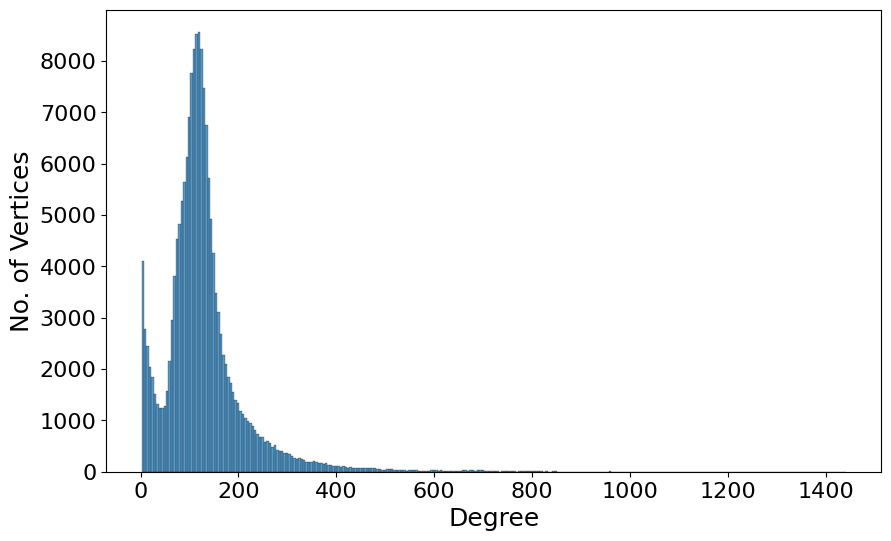

In [ ]:
reads_truth, read_id_idx = get_idx_maps(exp + 'read_ids', truth)
degree_array = load_read_degrees(degrees_file_path,read_id_idx)


edges = load_edges_as_numpy(exp + "edges.txt", exp + "edges.npy")
sample_weights = np.zeros_like(degree_array, dtype=np.float32)
sample_scale = np.ones_like(degree_array, dtype=np.float32)

In [ ]:
for n, d in enumerate(degree_array):
    sample_weights[n] = 1.0/d if d>0 else 0
    sample_scale[n] = max(1, np.log10(max(1, d)))

scaled = comp * sample_scale.reshape(-1, 1)

In [ ]:
np.savez(exp + 'data.npz', edges=edges, scaled=scaled)